# Binary Classification of Chest X-Rays

### By: Jonah Buchanan

## Import Libraries

In [2]:
from matplotlib import pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.datasets import mnist
import keras.callbacks as cb

Using TensorFlow backend.


## Display Images  
Shows a normal image of the lungs and an image of the lungs with pneumonia

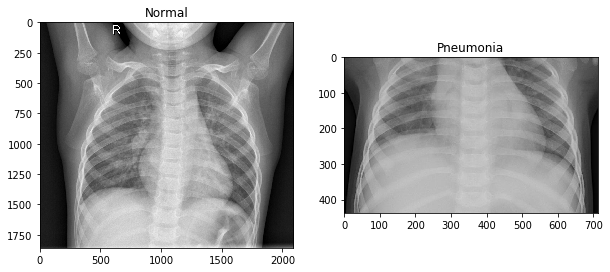

In [3]:
img_name = 'IM-0115-0001.jpeg'
img_normal = load_img('../Data/chest_xray/chest_xray/train/NORMAL/' + img_name)
img_name2 = 'person1_bacteria_1.jpeg'
img_pneumonia = load_img('../Data/chest_xray/chest_xray/train/PNEUMONIA/' + img_name2)

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
a1.set_title('Normal')
img_plot = plt.imshow(img_normal)

a2 = f.add_subplot(1,2,2)
a2.set_title('Pneumonia')
img_plot = plt.imshow(img_pneumonia)

## Load Data  
Load data using ImageDataGenerator which augments the data set. We want to augment the data because there are a lot more normal images than images with pneumonia. Thus augmenting the data allows us to create a better model. 

In [4]:
def load_data(batch_size):
    train_data_generator = ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

    test_data_generator = ImageDataGenerator(rescale = 1./255)

    training_set = train_data_generator.flow_from_directory('../Data/chest_xray/chest_xray/train',
                                                       target_size = (64,64),
                                                       batch_size = batch_size,
                                                       class_mode = 'binary')

    validation_generator = test_data_generator.flow_from_directory('../Data/chest_xray/chest_xray/val/', 
                                                               target_size = (64,64), 
                                                               batch_size = batch_size, 
                                                               class_mode = 'binary')

    test_set = test_data_generator.flow_from_directory('../Data/chest_xray/chest_xray/test/',
                                                   target_size = (64,64), 
                                                    batch_size = batch_size, 
                                                    class_mode = 'binary')
    return training_set, validation_generator, test_set

## Cost History  
Track loss at each iteration so that we can plot loss function of model

In [5]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

In [6]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

## Define Model 1 
This is our initial model. We will build upon this model to find what works best.  
Architecture:  
Input Dimension: (64, 64)  
First conv layer: 32 filters, (3,3), 'relu'  
Pooling Layer: Max Pooling function, (2,2)  
Second conv layer: 64 filters, (3,3),'relu'  
Pooling Layer: Max Pooling function, (2,2)  
Full-Connected Layer: 128 units, 'relu'  
Output: 1, 'sigmoid'  
Optimizer: Adadelta  

In [14]:
def init_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model

## Train Model 1

In [15]:
num_train = 5216 # number of training images
num_val = 17 # number of validation images
epochs = 10 # number of epochs
batch_size = 32 # size of batch
training_set, validation_generator, test_set = load_data(batch_size)
model = init_model()
history = LossHistory()
model.fit_generator(training_set, steps_per_epoch=num_train // batch_size, epochs=epochs,
                callbacks=[history],
                validation_data=validation_generator,
                validation_steps=num_val // batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 81s 494ms/step - loss: 0.4776 - accuracy: 0.7929 - val_loss: 0.3932 - val_accuracy: 0.9375
Epoch 2/10
163/163 [==============================] - 78s 479ms/step - loss: 0.2828 - accuracy: 0.8823 - val_loss: 0.6577 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 78s 478ms/step - loss: 0.2341 - accuracy: 0.9022 - val_loss: 1.0007 - val_accuracy: 0.5625
Epoch 4/10
163/163 [==============================] - 78s 480ms/step - loss: 0.2050 - accuracy: 0.9168 - val_loss: 0.4384 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 81s 500ms/step - loss: 0.1896 - accuracy: 0.9233 - val_loss: 0.6599 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 79s 482ms/step - loss: 0.1702 - accuracy: 0.9331 - val_loss: 1.2164 - val_accuracy: 0.6250
Epoch 7

## Test Model 1

In [16]:
scores = model.evaluate_generator(test_set)
print('The testing accuracy is: ', scores[1]*100)

The testing accuracy is:  91.98718070983887


## Plot Loss Function

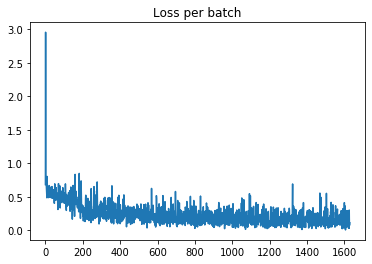

In [18]:
plot_losses(history.losses)

# 1. Investigate Impact of Regularization  
Now we will add regularization to Model 1 to try and improve the performance.

## 1.1 Define Model 2  
We will add L2 regularization to our two convolutional layers in model 1.

In [7]:
def init_model2():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    activity_regularizer=l2(1e-4),
                    input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', activity_regularizer=l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model

## 1.2 Train Model 2

In [8]:
num_train = 5216 # number of training images
num_val = 17 # number of validation images
epochs = 10 # number of epochs
batch_size = 32 # size of batch
training_set, validation_generator, test_set = load_data(batch_size)
model2 = init_model2()
history = LossHistory()
model2.fit_generator(training_set, steps_per_epoch=num_train // batch_size, epochs=epochs,
                callbacks=[history],
                validation_data=validation_generator,
                validation_steps=num_val // batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 137s 841ms/step - loss: 0.8453 - accuracy: 0.7772 - val_loss: 0.8565 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 84s 514ms/step - loss: 0.3357 - accuracy: 0.8727 - val_loss: 0.5861 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 82s 502ms/step - loss: 0.2848 - accuracy: 0.8957 - val_loss: 0.6511 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 82s 502ms/step - loss: 0.2471 - accuracy: 0.9105 - val_loss: 0.6781 - val_accuracy: 0.6875
Epoch 5/10
163/163 [==============================] - 82s 501ms/step - loss: 0.2232 - accuracy: 0.9208 - val_loss: 0.4647 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 82s 502ms/step - loss: 0.2113 - accuracy: 0.9273 - val_loss: 0.5119 - val_accuracy: 0.7500
Epoch 

## 1.3 Test Model 2

In [9]:
scores = model2.evaluate_generator(test_set)
print('The testing accuracy is: ', scores[1]*100)

The testing accuracy is:  88.94230723381042


## 1.4 Plot Loss Function of Model 2

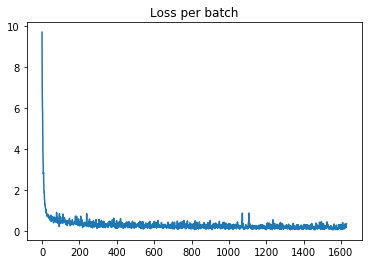

In [10]:
plot_losses(history.losses)

Adding L2 Regularization decreased the Test Accuracy of the model from 91.9% to 88.9%

## 1.5 Define Model 3  
Adding Dropout to Model 1

In [11]:
def init_model3():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model

## 1.6 Train Model 3

In [12]:
num_train = 5216 # number of training images
num_val = 17 # number of validation images
epochs = 10 # number of epochs
batch_size = 32 # size of batch
training_set, validation_generator, test_set = load_data(batch_size)
model3 = init_model3()
history = LossHistory()
model3.fit_generator(training_set, steps_per_epoch=num_train // batch_size, epochs=epochs,
                callbacks=[history],
                validation_data=validation_generator,
                validation_steps=num_val // batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 80s 491ms/step - loss: 0.5230 - accuracy: 0.7753 - val_loss: 0.4938 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 79s 485ms/step - loss: 0.3305 - accuracy: 0.8579 - val_loss: 0.4695 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 79s 484ms/step - loss: 0.2677 - accuracy: 0.8930 - val_loss: 0.5931 - val_accuracy: 0.7500
Epoch 4/10
163/163 [==============================] - 83s 510ms/step - loss: 0.2287 - accuracy: 0.9101 - val_loss: 0.4277 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 81s 494ms/step - loss: 0.2201 - accuracy: 0.9164 - val_loss: 0.6216 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 82s 501ms/step - loss: 0.2009 - accuracy: 0.9216 - val_loss: 0.3592 - val_accuracy: 0.9375
Epoch 7

## 1.7 Test Model 3

In [13]:
scores = model3.evaluate_generator(test_set)
print('The testing accuracy is: ', scores[1]*100)

The testing accuracy is:  90.06410241127014


## 1.8 Plot Loss Function of Model 3

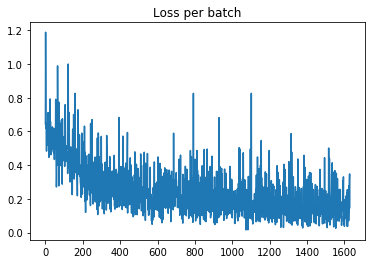

In [14]:
plot_losses(history.losses)

## 1.9 Summary of Impact of Regularization
Comparing Model 2 and Model 3, Adding Dropout to Model 1 resulted in a better test accuracy than L2 Regularization but both models performed worse than the model 1.

# 2. Investigate Impact of Optimization Methods  
Now we will investigate the impact of optimization methods by changing the optimization method in Model 1.

## 2.1 Define Model 4  
Model 1 with RMSprop as the optimizer

In [18]:
def init_model4():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
    return model

## 2.2 Train Model 4

In [19]:
num_train = 5216 # number of training images
num_val = 17 # number of validation images
epochs = 10 # number of epochs
batch_size = 32 # size of batch
training_set, validation_generator, test_set = load_data(batch_size)
model4 = init_model4()
history = LossHistory()
model4.fit_generator(training_set, steps_per_epoch=num_train // batch_size, epochs=epochs,
                callbacks=[history],
                validation_data=validation_generator,
                validation_steps=num_val // batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 78s 478ms/step - loss: 0.4285 - accuracy: 0.8163 - val_loss: 0.8841 - val_accuracy: 0.5625
Epoch 2/10
163/163 [==============================] - 77s 473ms/step - loss: 0.2522 - accuracy: 0.8940 - val_loss: 0.5162 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 79s 486ms/step - loss: 0.2048 - accuracy: 0.9181 - val_loss: 0.4108 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - 79s 483ms/step - loss: 0.1948 - accuracy: 0.9248 - val_loss: 0.9518 - val_accuracy: 0.5625
Epoch 5/10
163/163 [==============================] - 79s 482ms/step - loss: 0.1639 - accuracy: 0.9354 - val_loss: 0.6128 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 82s 504ms/step - loss: 0.1603 - accuracy: 0.9381 - val_loss: 0.3155 - val_accuracy: 0.8750
Epoch 7

##  2.3 Test Model 4

In [20]:
scores = model4.evaluate_generator(test_set)
print('The testing accuracy is: ', scores[1]*100)

The testing accuracy is:  92.62820482254028


## 2.4 Plot Loss Function of Model 4

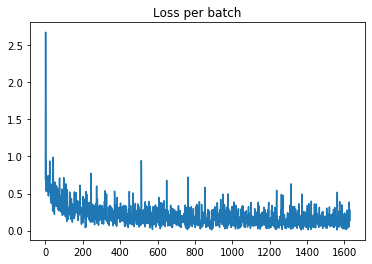

In [21]:
plot_losses(history.losses)

## 2.5 Define Model 5  
Use Adam as optimizer of Model 1

In [22]:
def init_model5():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    return model

## 2.6 Train Model 5

In [23]:
num_train = 5216 # number of training images
num_val = 17 # number of validation images
epochs = 10 # number of epochs
batch_size = 32 # size of batch
training_set, validation_generator, test_set = load_data(batch_size)
model5 = init_model5()
history = LossHistory()
model5.fit_generator(training_set, steps_per_epoch=num_train // batch_size, epochs=epochs,
                callbacks=[history],
                validation_data=validation_generator,
                validation_steps=num_val // batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 78s 480ms/step - loss: 0.3982 - accuracy: 0.8236 - val_loss: 0.3414 - val_accuracy: 0.7500
Epoch 2/10
163/163 [==============================] - 78s 477ms/step - loss: 0.2387 - accuracy: 0.8990 - val_loss: 0.3915 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 79s 485ms/step - loss: 0.2154 - accuracy: 0.9132 - val_loss: 0.5381 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 79s 486ms/step - loss: 0.1871 - accuracy: 0.9208 - val_loss: 0.2667 - val_accuracy: 0.9375
Epoch 5/10
163/163 [==============================] - 78s 482ms/step - loss: 0.1753 - accuracy: 0.9319 - val_loss: 0.5042 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 78s 476ms/step - loss: 0.1651 - accuracy: 0.9358 - val_loss: 0.3258 - val_accuracy: 0.8125
Epoch 7

## 2.7 Test Model 5

In [24]:
scores = model5.evaluate_generator(test_set)
print('The testing accuracy is: ', scores[1]*100)

The testing accuracy is:  88.78205418586731


## 2.8 Plot Loss Function of Model 5

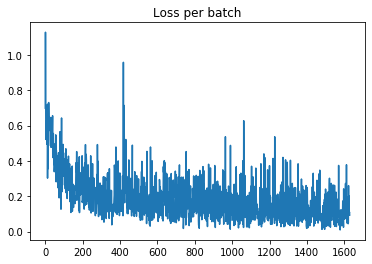

In [25]:
plot_losses(history.losses)

## 2.9 Summary of Impact of Optimizer

RMSprop did better than Adam and slightly better than model 1.

## 3. Investigate Impact of Architecture  
In this section we will try different architectures and see which model performs the best

## 3.1 Define Model 6  
Architecture: AlexNet  
Same as Model 1 with 3 additional convolutional layers and a another pooling layer.

In [26]:
def init_model6():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model

## 3.2 Train Model 6

In [27]:
num_train = 5216 # number of training images
num_val = 17 # number of validation images
epochs = 10 # number of epochs
batch_size = 32 # size of batch
training_set, validation_generator, test_set = load_data(batch_size)
model6 = init_model6()
history = LossHistory()
model6.fit_generator(training_set, steps_per_epoch=num_train // batch_size, epochs=epochs,
                callbacks=[history],
                validation_data=validation_generator,
                validation_steps=num_val // batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 80s 493ms/step - loss: 0.5739 - accuracy: 0.7427 - val_loss: 0.9109 - val_accuracy: 0.5625
Epoch 2/10
163/163 [==============================] - 80s 489ms/step - loss: 0.3850 - accuracy: 0.8294 - val_loss: 0.7048 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 78s 481ms/step - loss: 0.2491 - accuracy: 0.8959 - val_loss: 0.4946 - val_accuracy: 0.7500
Epoch 4/10
163/163 [==============================] - 80s 493ms/step - loss: 0.2131 - accuracy: 0.9120 - val_loss: 0.8463 - val_accuracy: 0.5625
Epoch 5/10
163/163 [==============================] - 81s 496ms/step - loss: 0.1869 - accuracy: 0.9254 - val_loss: 0.9529 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 82s 501ms/step - loss: 0.1773 - accuracy: 0.9312 - val_loss: 0.8311 - val_accuracy: 0.6250
Epoch 7

## 3.3 Test Model 6

In [28]:
scores = model6.evaluate_generator(test_set)
print('The testing accuracy is: ', scores[1]*100)

The testing accuracy is:  90.70512652397156


## 3.4 Plot Loss Function of Model 6

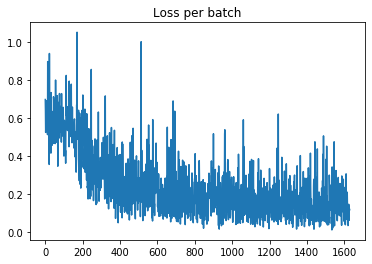

In [29]:
plot_losses(history.losses)

## 3.5 Define Model 7  
I will implement a model similar to model 3 but with the Adam optimizer and Average Pooling in the pooling layers

In [36]:
def init_model7():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(64, 64, 3)))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    return model

## 3.6 Train Model 7

In [37]:
num_train = 5216 # number of training images
num_val = 17 # number of validation images
epochs = 10 # number of epochs
batch_size = 32 # size of batch
training_set, validation_generator, test_set = load_data(batch_size)
model7 = init_model7()
history = LossHistory()
model7.fit_generator(training_set, steps_per_epoch=num_train // batch_size, epochs=epochs,
                callbacks=[history],
                validation_data=validation_generator,
                validation_steps=num_val // batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 81s 495ms/step - loss: 0.4313 - accuracy: 0.8012 - val_loss: 0.5295 - val_accuracy: 0.6875
Epoch 2/10
163/163 [==============================] - 79s 486ms/step - loss: 0.3032 - accuracy: 0.8656 - val_loss: 0.5209 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 83s 508ms/step - loss: 0.2753 - accuracy: 0.8808 - val_loss: 0.7206 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 82s 505ms/step - loss: 0.2650 - accuracy: 0.8886 - val_loss: 0.4631 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 84s 514ms/step - loss: 0.2518 - accuracy: 0.8919 - val_loss: 0.4025 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 83s 508ms/step - loss: 0.2375 - accuracy: 0.9043 - val_loss: 0.4908 - val_accuracy: 0.8750
Epoch 7

 ## 3.7 Test Model 7

In [38]:
scores = model7.evaluate_generator(test_set)
print('The testing accuracy is: ', scores[1]*100)

The testing accuracy is:  89.26281929016113


## 3.8 Plot Loss Function of Model 7

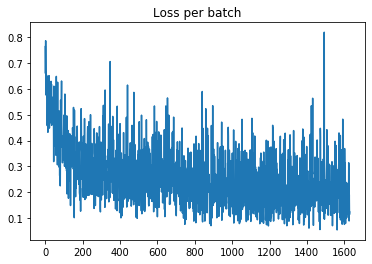

In [39]:
plot_losses(history.losses)

## 3.9 Summary of Impact of Architecture

The architecture of model 6 performed better than 7 but both performed worse than model 1.

# 4. Impact of Hyperparameters  
In this section we will try and improve Model 1 by fine tuning the hyperparameters

## 4.1 Define Model 8  
This model changes the kernel size of the convolutional layers of Model 1.

In [40]:
def init_model8():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5),
                    activation='relu',
                    input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model

## 4.2 Train Model 8

In [41]:
num_train = 5216 # number of training images
num_val = 17 # number of validation images
epochs = 10 # number of epochs
batch_size = 32 # size of batch
training_set, validation_generator, test_set = load_data(batch_size)
model8 = init_model8()
history = LossHistory()
model8.fit_generator(training_set, steps_per_epoch=num_train // batch_size, epochs=epochs,
                callbacks=[history],
                validation_data=validation_generator,
                validation_steps=num_val // batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 80s 494ms/step - loss: 0.5358 - accuracy: 0.7575 - val_loss: 0.4535 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 82s 503ms/step - loss: 0.2871 - accuracy: 0.8740 - val_loss: 0.5656 - val_accuracy: 0.7500
Epoch 3/10
163/163 [==============================] - 82s 505ms/step - loss: 0.2305 - accuracy: 0.9061 - val_loss: 0.5906 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 83s 508ms/step - loss: 0.2086 - accuracy: 0.9135 - val_loss: 1.3264 - val_accuracy: 0.5625
Epoch 5/10
163/163 [==============================] - 81s 494ms/step - loss: 0.1901 - accuracy: 0.9227 - val_loss: 0.3727 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 80s 489ms/step - loss: 0.1638 - accuracy: 0.9340 - val_loss: 1.0221 - val_accuracy: 0.5625
Epoch 7

## 4.3 Test Model 8

In [42]:
scores = model8.evaluate_generator(test_set)
print('The testing accuracy is: ', scores[1]*100)

The testing accuracy is:  85.09615659713745


## 4.4 Plot Loss Function of Model 8

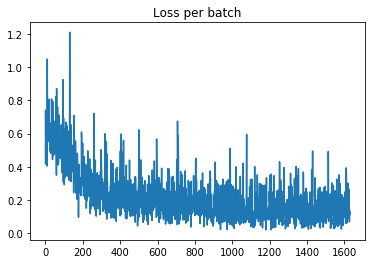

In [43]:
plot_losses(history.losses)

## 4.5 Define Model 9  
Same model as model 1 but we will change the batch size.

In [44]:
def init_model9():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model

## 4.6 Train Model 9

In [45]:
num_train = 5216 # number of training images
num_val = 17 # number of validation images
epochs = 10 # number of epochs
batch_size = 128 # size of batch
training_set, validation_generator, test_set = load_data(batch_size)
model9 = init_model9()
history = LossHistory()
model9.fit_generator(training_set, steps_per_epoch=num_train // batch_size, epochs=epochs,
                callbacks=[history],
                validation_data=validation_generator,
                validation_steps=num_val // batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
40/40 [==============================] - 74s 2s/step - loss: 0.5887 - accuracy: 0.7313 - val_loss: 0.8547 - val_accuracy: 0.5000
Epoch 2/10
40/40 [==============================] - 76s 2s/step - loss: 0.5017 - accuracy: 0.7887 - val_loss: 0.9544 - val_accuracy: 0.5000
Epoch 3/10
40/40 [==============================] - 74s 2s/step - loss: 0.4292 - accuracy: 0.8237 - val_loss: 0.8172 - val_accuracy: 0.6250
Epoch 4/10
40/40 [==============================] - 75s 2s/step - loss: 0.3523 - accuracy: 0.8445 - val_loss: 0.4240 - val_accuracy: 0.8125
Epoch 5/10
40/40 [==============================] - 75s 2s/step - loss: 0.2902 - accuracy: 0.8754 - val_loss: 0.3744 - val_accuracy: 0.9375
Epoch 6/10
40/40 [==============================] - 73s 2s/step - loss: 0.2687 - accuracy: 0.8846 - val_loss: 0.8449 - val_accuracy: 0.6250
Epoch 7/10
40/40 [===================

## 4.7 Test Model 9

In [46]:
scores = model9.evaluate_generator(test_set)
print('The testing accuracy is: ', scores[1]*100)

The testing accuracy is:  87.0192289352417


## 4.8 Plot Loss Function of Model 9

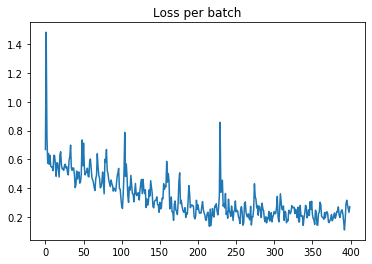

In [47]:
plot_losses(history.losses)

## 4.9 Summary of Impact of Hyperparameters

Model 9 performed better than model 8 but both models performed worse than model 1.

# 5. Analysis of Performance

Model 1: 91.98718070983887  
Model 2: 88.94230723381042  
Model 3: 90.06410241127014  
Model 4: 92.62820482254028  
Model 5: 88.78205418586731   
Model 6: 90.70512652397156  
Model 7: 89.26281929016113  
Model 8: 85.09615659713745  
Model 9: 87.0192289352417  

We have evaluated performance of the model be applying the model to a batch of the test set and calculating the percent of correctly labeled images. Model 4 performed the best with a test accuracy of 92.6%. Model 4 is LeNet-5 with RMSprop. Although most of our manipulations of model 1 did not improve the performance, we can see that different architectures impact the result of the model 